In [6]:
# This jupyter notebook is used to plot Figure 5 in Model 1
# Required packages: numpy, matplotlib
# 在开始所有内容之前，请先顺利运行本代码块确保环境中已经安装所需的包

import numpy as np
import matplotlib.pyplot as plt

鉴于阅读本项目的很多同学可能对数学建模不太熟悉，故我在这里讲解一下微分方程建模的求解方法，以下内容均为我的个人理解，纯手码无AI，有任何问题欢迎在项目里提issue进行交流。对于熟悉这部分内容的同学可以直接跳过即可。

## 欧拉法求解微分方程
绝大多数微分方程的数学建模问题，在建立完成微分方程组之后，都可以使用欧拉法来离散化求解，用于**模拟**微分方程组所描述的数学问题。

欧拉法是一种非常常见的微分方程数值解法，核心思路就是将微分方程离散化，不断迭代就可以绘制出微分方程的动态图像。

例如，对于如下的一个微分方程：
$$
    \frac{\mathbf{d}y}{\mathbf{d}t} = f(t)
$$
- 上面这个式子中的$y$是我们关心的变量（可以是经济学中的商品价格、生物学中的种群数量、化学中某种分子的浓度等），且这个变量$y$是一个关于时间$t$的函数，故也可将$y$写作$y(t)$. 为了便于理解，可以想象$y$是种群数量（下文提到“种群数量”则将其理解为这个式子中的$y$即可）；
- 左侧一阶导理解为“变化速率”，从而使得我们可以通过这个式子来刻画这个变量随时间的变化情况；
- 右侧的$f(t)$用于描述种群数量在时刻$t$的变化情况。
  
将一阶导离散化，可以表示为：
$$
    \frac{\Delta y(t)}{\Delta t} = f(t) 
$$
将上面$\Delta$变化量展开可以表示为：
$$
    \frac{y(t_{n+1}) - y(t_{n})}{t_{n+1} - t_{n}} = f(t_{n})
$$
推导上面式子可以得到种群数量的迭代公式：
$$
    y(t_{n+1}) = f(t_{n})(t_{n+1} - t_{n}) + y(t_{n})
$$
根据上面这个式子我们就可以得到种群数量的迭代求解公式。通过这个式子我想说明以下几点：
1. **对于微分方程类的问题**而言，我们所谓的**数学建模**，其实就是需要**设计一个合适的位于右侧的$f(t)$函数**，可以用于描述我们关心的变量$y$关于时间的变化情况
2. 要计算下一时刻点的种群数量$y(t_{n+1})$，需要知道右侧的所有内容，包括三个部分：$f(t)$、$(t_{n+1}-t_n)$、$y(t_{n})$，其中：
    - $f(t)$是我们设计出来的函数，也就是数学建模的目标，在计算时这个函数已知；
    - $(t_{n+1}-t_n)$是一个时间步长，在模拟时可以直接人为设定为具体的很小的值（例如0.01），理论上来说数值越小越精确，但通常而言0.01就够用了；
    - $y(t_{n})$是上一个时刻点的种群数量，也就是上一次刚计算出来的结果。

意味着我们只需要一开始有一个初值$y_0$，那么就可以根据设计的$f(t)$迭代出一系列的$y(t_1), y(t_2), \cdots, y(t_n)$，从而相当于就模拟出了整个种群变化的迭代过程。读到这里我们可以知道：
- $f(t)$是我们需要设计的目标，也就是我们需要建立的**数学模型**，比赛中遇到的微分方程问题本质上也只是需要设计一个合适的$f(t)$而已，不过可能涉及到更多变量，从而建立成一个微分方程组；
- 时间步长$(t_{n+1}-t_n)$、种群数量的初值$y_0$是在计算时需要我们自己指定的具体的值，我们称之为**参数**。

此外，对于$f(t)$我们通常不会自己从头设计（当然如果你对于某个问题有非常创新的独特见解那也可以），大家都会在一些经典的微分方程模型上进行拓展，例如：[传染病模型（SIR模型）](https://simple.wikipedia.org/wiki/SIR_model)、[捕食者-猎物模型（Lotka-Volterra）](https://simple.wikipedia.org/wiki/Predator-prey_equations)等。对于这些基本的数学模型是需要各位有一定了解的，但这些模型其实也并不要求有过多的积累，因为其实在比赛中遇到具体的问题再去搜索相关文献学习这些基本模型其实也都完全来得及。

但如果想要取得一个好的奖项，我们通常需要在这些经典模型的基础上进一步拓展，使得我们的模型能够更好地贴合我们要解决的问题。我个人认为，**对于建模手而言**读优秀论文最重要的就是学习别人都是**如何拓展基础模型**的，多读多思考别人这样的拓展**有什么优劣**。而具体我是如何拓展我们的模型可以阅读我的[中文博客文章](https://www.cnblogs.com/JQ-Luke/p/18858431)，其中关于模型一的思路、原理和公式推导部分。

## 微分方程模型中的参数
在理解了微分方程建模与欧拉法求解的基本思想之后，我想再着重说一下我对参数的理解，以及如何调参的问题。按照我个人理解，微分方程中涉及到的参数类型可以将其划分为三类（类别都是我自己取的，应该除了这里之外没有任何地方能看到这样的名称，具体参数的例子可以在下面代码的注释中看到）：
- 初值型参数：在迭代一开始的初值，我们必须要先设置一个初值$y_0$才能通过一个迭代公式计算模拟出整个序列$y_1, y_2, \cdots, y_n$；
- 时间型参数：总时间尺度、时间步长，这两个参数确定了欧拉法实现时的for循环的迭代轮次；
- 系数型参数：这部分包含在我们设计的函数$f(t)$当中，通常用于刻画变量本身或是两个变量之间相互作用的关系。

之前的例子中我们已经提到过前两种参数，对于系数型参数以我们论文中的模型一为例（请先去读论文PDF或者中文博客中模型一的部分），就是其中的死亡率$\gamma$、捕食参数$\alpha$、被捕食参数$\beta$等。在具体的公式中，例如我们选取食物链中最高营养级的氮含量微分方程公式：
$$
\frac{\mathrm{d}N_k(t)}{\mathrm{d}t(t)}=\beta_{k-1,k}N_{k-1}(t)N_k(t)-\gamma _kN_k(t)
$$

此时右侧的$f(t)$由两项构成，其中$\beta_{k-1,k}N_{k-1}(t)N_k(t)$表示它从上一级营养级中捕食来的氮含量，$-\gamma _kN_k(t)$表示由于自然死亡而将尸体中的氮算作是环境中的有机氮，符号正负分别表示该营养级中氮元素的流入和流出。

在具体到其中的第一项时，我们相当于假设$\beta_{k-1,k}$这个常数因子乘以第$k$营养级的氮含量$N_k(t)$能够得到第$(k-1)$级中被捕食转化的氮比率，再乘以第$(k-1)$级的氮含量$N_{k-1}$就得到了第$(k-1)$级被捕食而流入第$k$级的氮含量。这里我们可以发现，这个$\beta_{k-1,k}$常数因子好像有**魔法**一般，只管乘上两个已知的量，就可以得到我们想要的变化量。读到这里很自然就会想到，如果要真实模拟系统中变量的变化情况，这个参数的具体的值应该很难确定吧。这里我尝试回答几个可能会有的问题：

- 我们该如何确定这个参数的取值呢？
> 答：手动**调参**，说人话就是凭感觉尝试，不断地调整输入不同的参数最后输出一个好看的结果（这个过程通常被戏称为“炼丹”）。你需要能够**理解模型中每一项的意义**，从而知道修改每个参数之后会对模型输出的图像带来什么影响，哪个参数高了那就调低一点，低了就调高一点（这也是**为什么编程手必须懂模型**）。最终调出来的图像要**以能够在论文中更好地呈现为目标**（一切为了论文服务，因为最终提交的也只有一篇论文），像我在代码中，就是通过调节参数，将图像中种群波动的周期调节在12左右，然后给x轴强行赋上月份的含义。


- 这个参数一定是一个常数吗？能不能让这个参数也是一个关于时间t的函数？
> 答：当然可以，整个$f(x)$函数都是由你自己来设计的，你想怎么加就怎么加，但前提是**能解释**、且**效果好**。而在后面的模型二中，我们就拓展了死亡率系数$\gamma$，将其设置为一个关于时间采用三角函数周期变化的函数$\gamma(t) = A\sin (\omega t + \phi)$，从而模拟了周期性的季节因素对死亡率的影响。但这里又会发现，如果将这些系数参数采用函数形式，那么我们又会引入新的更多参数（例如这里的$A, \omega, \phi$）。


- 如何在论文中去解释我们自行指定的参数？
> 答：由于参数是我们自己炼丹炼出来的，这在论文中当然不能说是我们随便指定炼出来的。推荐的做法（某些o奖论文的做法）是**引用**一些文章或是数据库，然后在论文中说我们基于这些论文和数据库，从而确定了参数（但数据库里会有这种魔法一样的参数吗？好难猜呀）。同时这里可以将参数**绘制一个参数表格**放在论文中，或者将表格放到附录里去，这会显得论文更严谨，表示数据都是可复现的。但具体加不加可以根据论文篇幅而定，不够的话可以加进去凑页数，有多余内容那也可以删除。此外，还建议在论文最后的自己评价的优缺点部分中，缺点里说我们的参数设置可能存在偏差，而真实的参数数值设定还需要进一步更深入的研究（联想一下高中物理课本中卡文迪许为了计算出一个万有引力常数G进行的实验）。


到这里我们就完全讲解了关于微分方程模型中，如何建模（设计$f(t)$）、如何求解（欧拉法迭代模拟）、如何展现在论文中（调参炼丹选出好看的图）。在理解了这些之后我相信大家都可以解决绝大多数微分方程建模问题了。

接下来可以继续阅读下面代码，下面代码用于绘制我们参赛论文中的图5，对应的是我们论文中模型一（论文中公式2,3,4,5）的求解结果，是我在赛中由Claude3.5辅助下写出来的，主要分为三部分，先是参数和初值的设置，然后是欧拉法求解，最后再绘制图像。推荐使用步骤：
1. 成功运行下面python代码块，如果报错可能是你没有运行一开始的包导入代码块，或者环境配置有问题（请自行解决）；
2. 读懂其中欧拉法迭代求解的代码，直接对照论文中的公式应该很容易就能看懂；
3. 尝试修改一开始的参数，多次运行下面代码块，观察输出图像的变化情况。

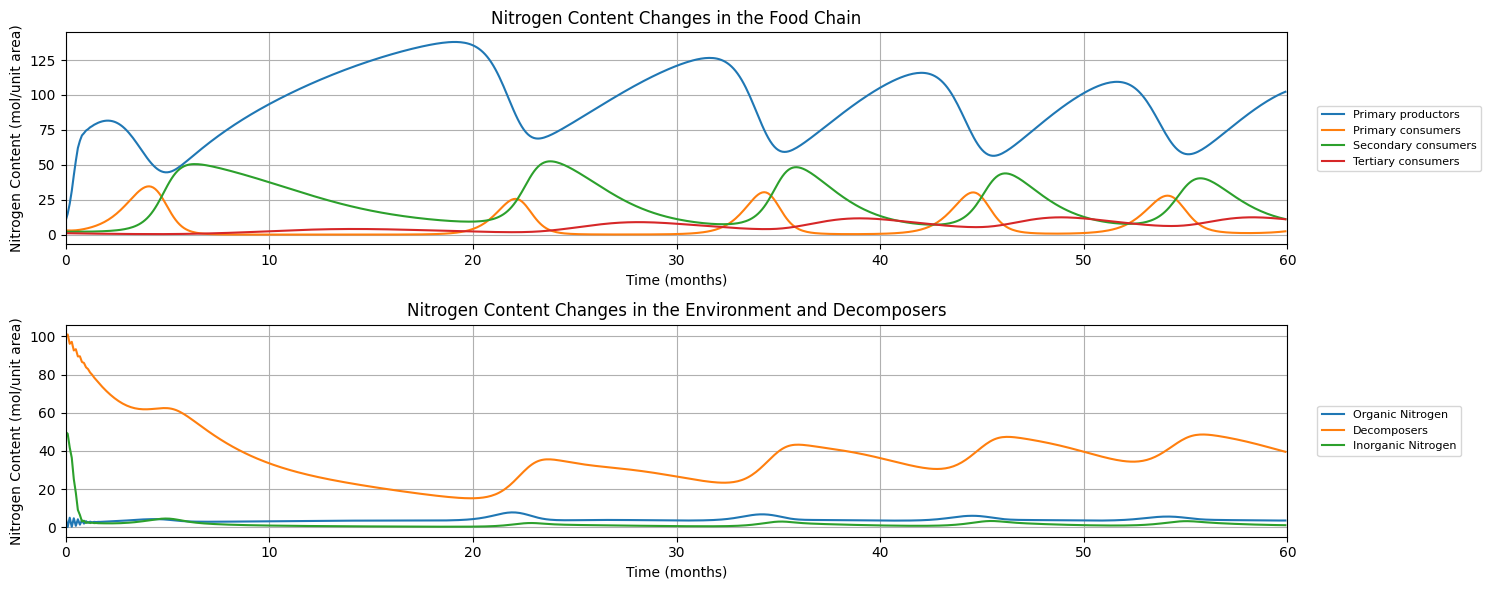

In [17]:
# Figure 5. The result of FENCM

##################################################
## 1. Parameters 设置参数
##################################################

################
# 1.1 系数型参数，各种速率参数的设定
################
k = 3  # number of trophic levels # 营养级数量，此参数不能修改

# 尝试修改这些参数再运行代码，观察输出的图像变化
r = 0.1  # Increased growth rate # 初级生产者的生长率
gamma = np.array([0.01, 0.2, 0.05, 0.3])  # Decreased death rate # 各营养级的死亡率
alpha = np.array([0.02, 0.05, 0.03])  # Decreased predation rate # 捕食率
beta = np.array([0.015, 0.04, 0.015])  # conversion efficiency # 转化效率
d = 0.2  # decomposition rate # 分解速率
delta = 0.12  # decomposer conversion efficiency # 分解者转化效率
gamma_D = 0.5  # decomposer death rate # 分解者死亡率

################
# Time parameters
# 1.2 时间型参数，控制迭代的时间步长和总时间
################
# 尝试修改以下两个时间参数再运行代码，观察输出的图像变化
t_max = 60 # 总时间尺度，例如修改为80
dt = 0.01 # 时间步长，例如修改为0.05、0.1

t = np.arange(0, t_max, dt)
n_steps = len(t)

################
# Initial conditions
# 1.3 初值型参数，各种氮含量的初始值
################
# Initialize arrays for storing results
# 在开始赋值之前先创建初始化数组
N = np.zeros((k+1, n_steps))
N_org = np.zeros(n_steps)
N_D = np.zeros(n_steps)  
N_inorg = np.zeros(n_steps)

# Set initial conditions
# 赋值初始氮含量
# 尝试修改下面的初值再运行代码，观察输出的图像变化
N[:, 0] = [10, 3, 2, 1] # 各营养级的初始氮含量
N_org[0] = 5 # 有机氮的初始含量
N_D[0] = 100 # 分解者的初始含量
N_inorg[0] = 50 # 无机氮的初始含量



##################################################
## 2. 使用欧拉法迭代来求解微分方程
## Euler method for solving the system
##################################################

# for循环在每个时间步长上迭代，轮迭代中更新所有变量
# 具体的微分方程见论文正文中2-5式，或是中文博客中的1-4式
for i in range(n_steps-1): 
    # Trophic levels 各营养级的氮含量
    N[0, i+1] = N[0, i] + dt * (r * N_inorg[i] * N[0, i] - gamma[0] * N[0, i] - alpha[0] * N[0, i] * N[1, i])
    
    for j in range(1, k):
        N[j, i+1] = N[j, i] + dt * (beta[j-1] * N[j-1, i] * N[j, i] - gamma[j] * N[j, i] - 
                                   alpha[j] * N[j, i] * N[j+1, i])
    
    N[k, i+1] = N[k, i] + dt * (beta[k-1] * N[k-1, i] * N[k, i] - gamma[k] * N[k, i])
    
    # Organic nitrogen 有机氮计算
    transfer_sum = sum((alpha[j] - beta[j]) * N[j, i] * N[j+1, i] for j in range(k))
    mortality_sum = sum(gamma[j] * N[j, i] for j in range(k+1))
    
    N_org[i+1] = N_org[i] + dt * (transfer_sum + mortality_sum + gamma_D * N_D[i] - d * N_D[i] * N_org[i])
    
    # Decomposers 分解者计算
    N_D[i+1] = N_D[i] + dt * (delta * N_D[i] * N_org[i] - gamma_D * N_D[i])
    
    # Inorganic nitrogen 无机氮计算
    N_inorg[i+1] = N_inorg[i] + dt * ((d - delta) * N_D[i] * N_org[i] - r * N_inorg[i] * N[0, i])


##################################################
## 3. Plotting 绘图
##################################################

plt.figure(figsize=(15, 6))

# 绘制营养级
# plot trophic levels
plt.subplot(2, 1, 1)
plt.xlim(0, t_max)  # Limit x-axis to actual data range

plt.plot(t, N[0], label=f'Primary productors')
plt.plot(t, N[1], label=f'Primary consumers')
plt.plot(t, N[2], label=f'Secondary consumers')
plt.plot(t, N[3], label=f'Tertiary consumers')
plt.title('Nitrogen Content Changes in the Food Chain')
plt.xlabel('Time (months)')
plt.ylabel('Nitrogen Content (mol/unit area)')
plt.legend(fontsize=8, loc='center left', bbox_to_anchor=(1.02, 0.5))  # Position legend outside plot
plt.grid(True)

# 将有机氮、分解者和无机氮绘制在同一个图中
# plot organic nitrogen, decomposers, and inorganic nitrogen
plt.subplot(2, 1, 2)
plt.xlim(0, t_max)  # Limit x-axis to actual data range
plt.plot(t, N_org, label='Organic Nitrogen')
plt.plot(t, N_D, label='Decomposers')
plt.plot(t, N_inorg, label='Inorganic Nitrogen')
plt.title('Nitrogen Content Changes in the Environment and Decomposers')
plt.xlabel('Time (months)')
plt.ylabel('Nitrogen Content (mol/unit area)')
plt.legend(fontsize=8, loc='center left', bbox_to_anchor=(1.02, 0.5))  # Position legend outside plot
plt.grid(True)

plt.tight_layout()
plt.show()

在最后，根据上面代码我也想要再进一步说明几点：
1. 微分方程最终求解的结果在论文中的呈现其实就是一个图像，表示了我们的模型对于整个系统（在我们论文中指的是生态系统中各部分的氮含量）的**模拟**，意味着如果我们知道初值，以及各种参数，那么我们的模型就可以通过数值模拟的方式，来预测整个系统的随时间的动态变化情况。
2. 因此我们可以知道，微分方程模型的作用其实就仅仅停留在“**模拟**”这一层面。而如果题目要求我们进行优化（例如22年美赛A题，要求优化自行车选手的功率分配策略），或者是提出一个好的方案（例如25年美赛E题，最终的信中要写一个耕作建议），其实这都需要我们能够对某一个（运行在我们已建立的微分方程模型上的）策略进行“**评估**”。这意味着我们除了要建立一个微分方程模型之外，或许还需要建立一个“**评价指标**”的数学模型。而这一点是我们在比赛都快要结束的时候才意识到的，这才临时在论文中加了两个指标（一个用于表示收获量，另一个氮流通速率用于表示生态系统的稳定性）。

上面这两点其实是我个人在打过几次数模之后自己总结出来的经验，更多都是在赛后学了更多东西之后才自己领悟出来的。如果是首次接触数模的初学者，其实不必考虑这么多，更重要的是通过我的这个项目，体会数学建模比赛的整个流程。